In [1]:
# 1. Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, median_absolute_error
from scipy import stats
import os
import kagglehub
import time
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully")


All libraries imported successfully


In [2]:
# 2. Data Loading - Download and load from KaggleHub
print("Downloading dataset via KaggleHub...")

try:
    dataset_path = kagglehub.dataset_download("farkhod77/abalone-age-predict")
    print(f"Dataset downloaded to local cache directory: {dataset_path}")

    csv_file = os.path.join(dataset_path, "abalone.data.csv")
    df = pd.read_csv(csv_file)

    print(f"Data loaded successfully from: {csv_file}")

    if df.empty:
        print("Warning: Dataset is empty")
    else:
        print(f"Dataset shape: {df.shape}")
        print(f"Number of features: {df.shape[1] - 1}")
        print(f"Number of samples: {df.shape[0]}")

        print("\nData preview (first 5 rows):")
        display(df.head())

except Exception as e:
    print(f"Error occurred while reading file - {e}")

Dataset downloaded to local cache directory: /Users/a1/.cache/kagglehub/datasets/farkhod77/abalone-age-predict/versions/1
Data loaded successfully from: /Users/a1/.cache/kagglehub/datasets/farkhod77/abalone-age-predict/versions/1/abalone.data.csv
Dataset shape: (4177, 9)
Number of features: 8
Number of samples: 4177

Data preview (first 5 rows):


,gender,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
 # 3. Check and adjust column names
print("Checking column names...")

if len(df.columns) == 9 and 'gender' not in df.columns:
    expected_columns = ['gender', 'Length', 'Diameter', 'Height', 'Whole weight',
                       'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
    df.columns = expected_columns
    print("Correct column names set")

print("Current column names:", df.columns.tolist())

Checking column names...
Current column names: ['gender', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']


In [4]:
# 4. Data Preprocessing
print("Starting enhanced data preprocessing...")

def preprocessing(df):
    data = df.copy()

    # Encode categorical variable
    le = LabelEncoder()
    data['gender_encoded'] = le.fit_transform(data['gender'])
    print(f"Gender encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

    # Robust outlier removal using IQR method
    def remove_outliers_robust(df, feature):
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

    original_size = len(data)
    for feature in ['Height', 'Length', 'Diameter']:
        data = remove_outliers_robust(data, feature)
    print(f"Removed {original_size - len(data)} outlier samples")

    # Create new engineered features
    data['Volume'] = data['Length'] * data['Diameter'] * data['Height']
    data['Density'] = data['Whole weight'] / (data['Volume'] + 1e-6)
    data['Weight_ratio'] = data['Shell weight'] / data['Whole weight']
    data['Length_Diameter_ratio'] = data['Length'] / data['Diameter']

    print("New features created: Volume, Density, Weight_ratio, Length_Diameter_ratio")

    # Create age groups for analysis
    def age_group(rings):
        if rings <= 8: return 'Young'
        elif rings <= 11: return 'Adult'
        else: return 'Old'

    data['Age_group'] = data['Rings'].apply(age_group)
    print("Age groups created: Young (<8), Adult (9-11), Old (≥12)")

    return data

data_clean = preprocessing(df)
print(f"Final dataset shape: {data_clean.shape}")

Starting enhanced data preprocessing...
Gender encoding: {'F': 0, 'I': 1, 'M': 2}
Removed 69 outlier samples
New features created: Volume, Density, Weight_ratio, Length_Diameter_ratio
Age groups created: Young (<8), Adult (9-11), Old (≥12)
Final dataset shape: (4108, 15)


Analyzing engineered features...

New features statistics:
Volume: Mean=0.0351, Std=0.0205
Density: Mean=24.4301, Std=3.5834
Weight_ratio: Mean=0.2948, Std=0.0455
Length_Diameter_ratio: Mean=1.2905, Std=0.0535

-feature distribution and relationship analysis-
Basic Feature Distribution Analysis...


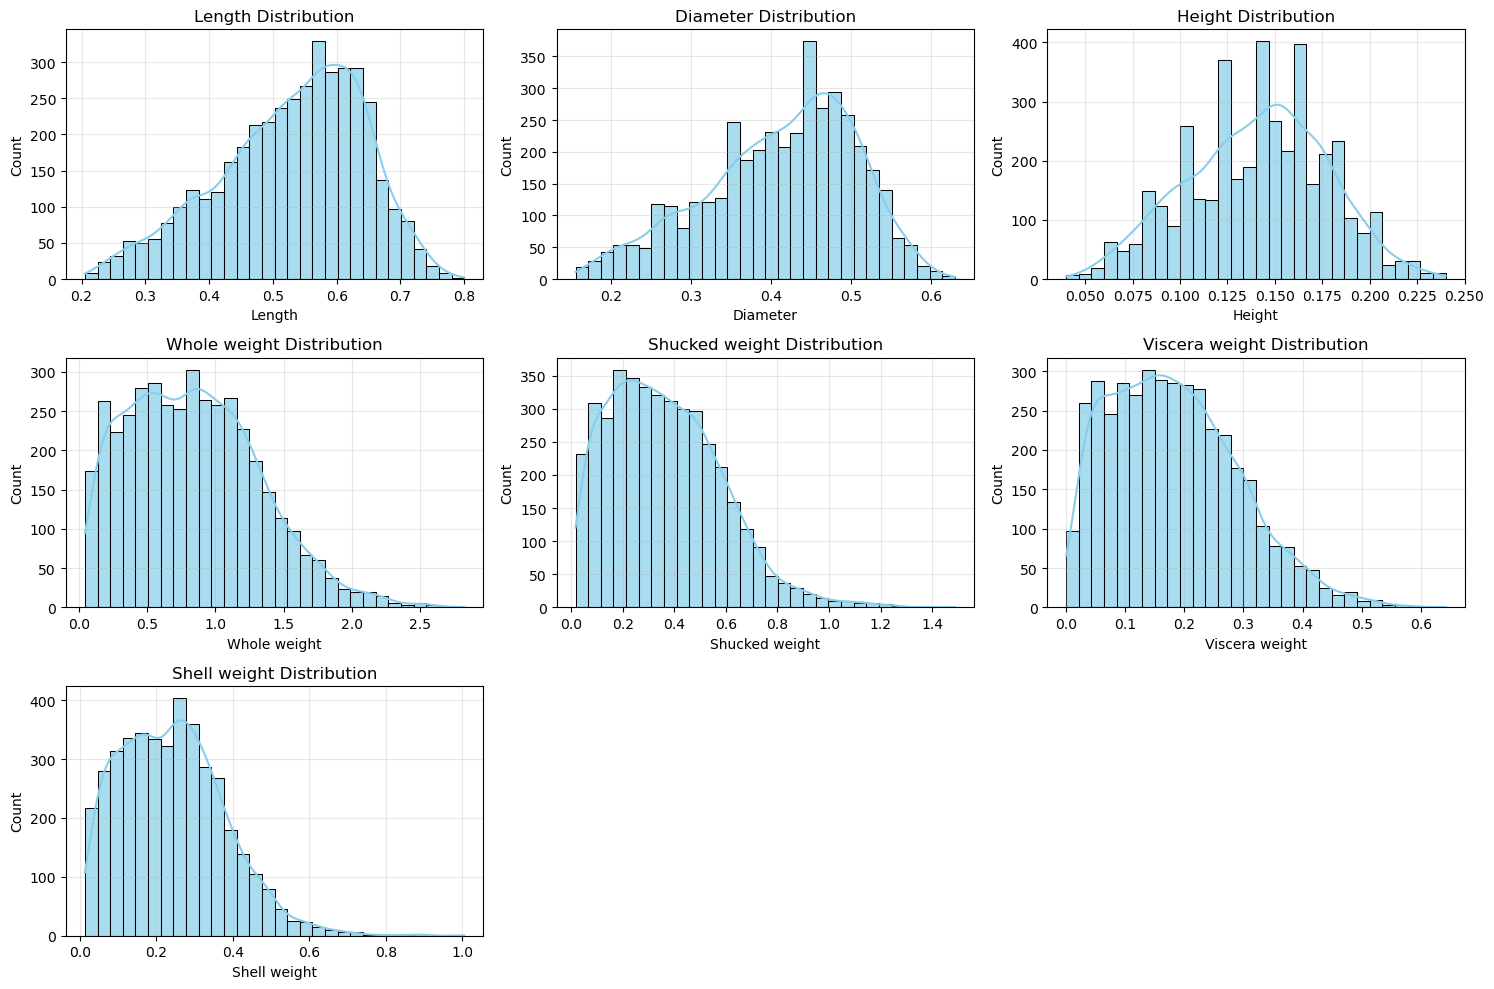

In [5]:
# 5. Feature Engineering Analysis
print ("Analyzing engineered features...")
new_features = ['Volume', 'Density', 'Weight_ratio', 'Length_Diameter_ratio']
print("\nNew features statistics:")
for feature in new_features:
    print(f"{feature}: Mean={data_clean[feature].mean():.4f}, Std={data_clean[feature].std():.4f}")

print("\n-feature distribution and relationship analysis-")

# （1）. Basic Feature Distribution Histograms
print("Basic Feature Distribution Analysis...")

basic_features = ['Length', 'Diameter', 'Height', 'Whole weight', 
                  'Shucked weight', 'Viscera weight', 'Shell weight']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(basic_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data_clean[feature], kde=True, bins=30, alpha=0.7, color='skyblue')
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Exploring Relationships Between All Numerical Features and Rings...
Analyzing 11 numerical features vs Rings


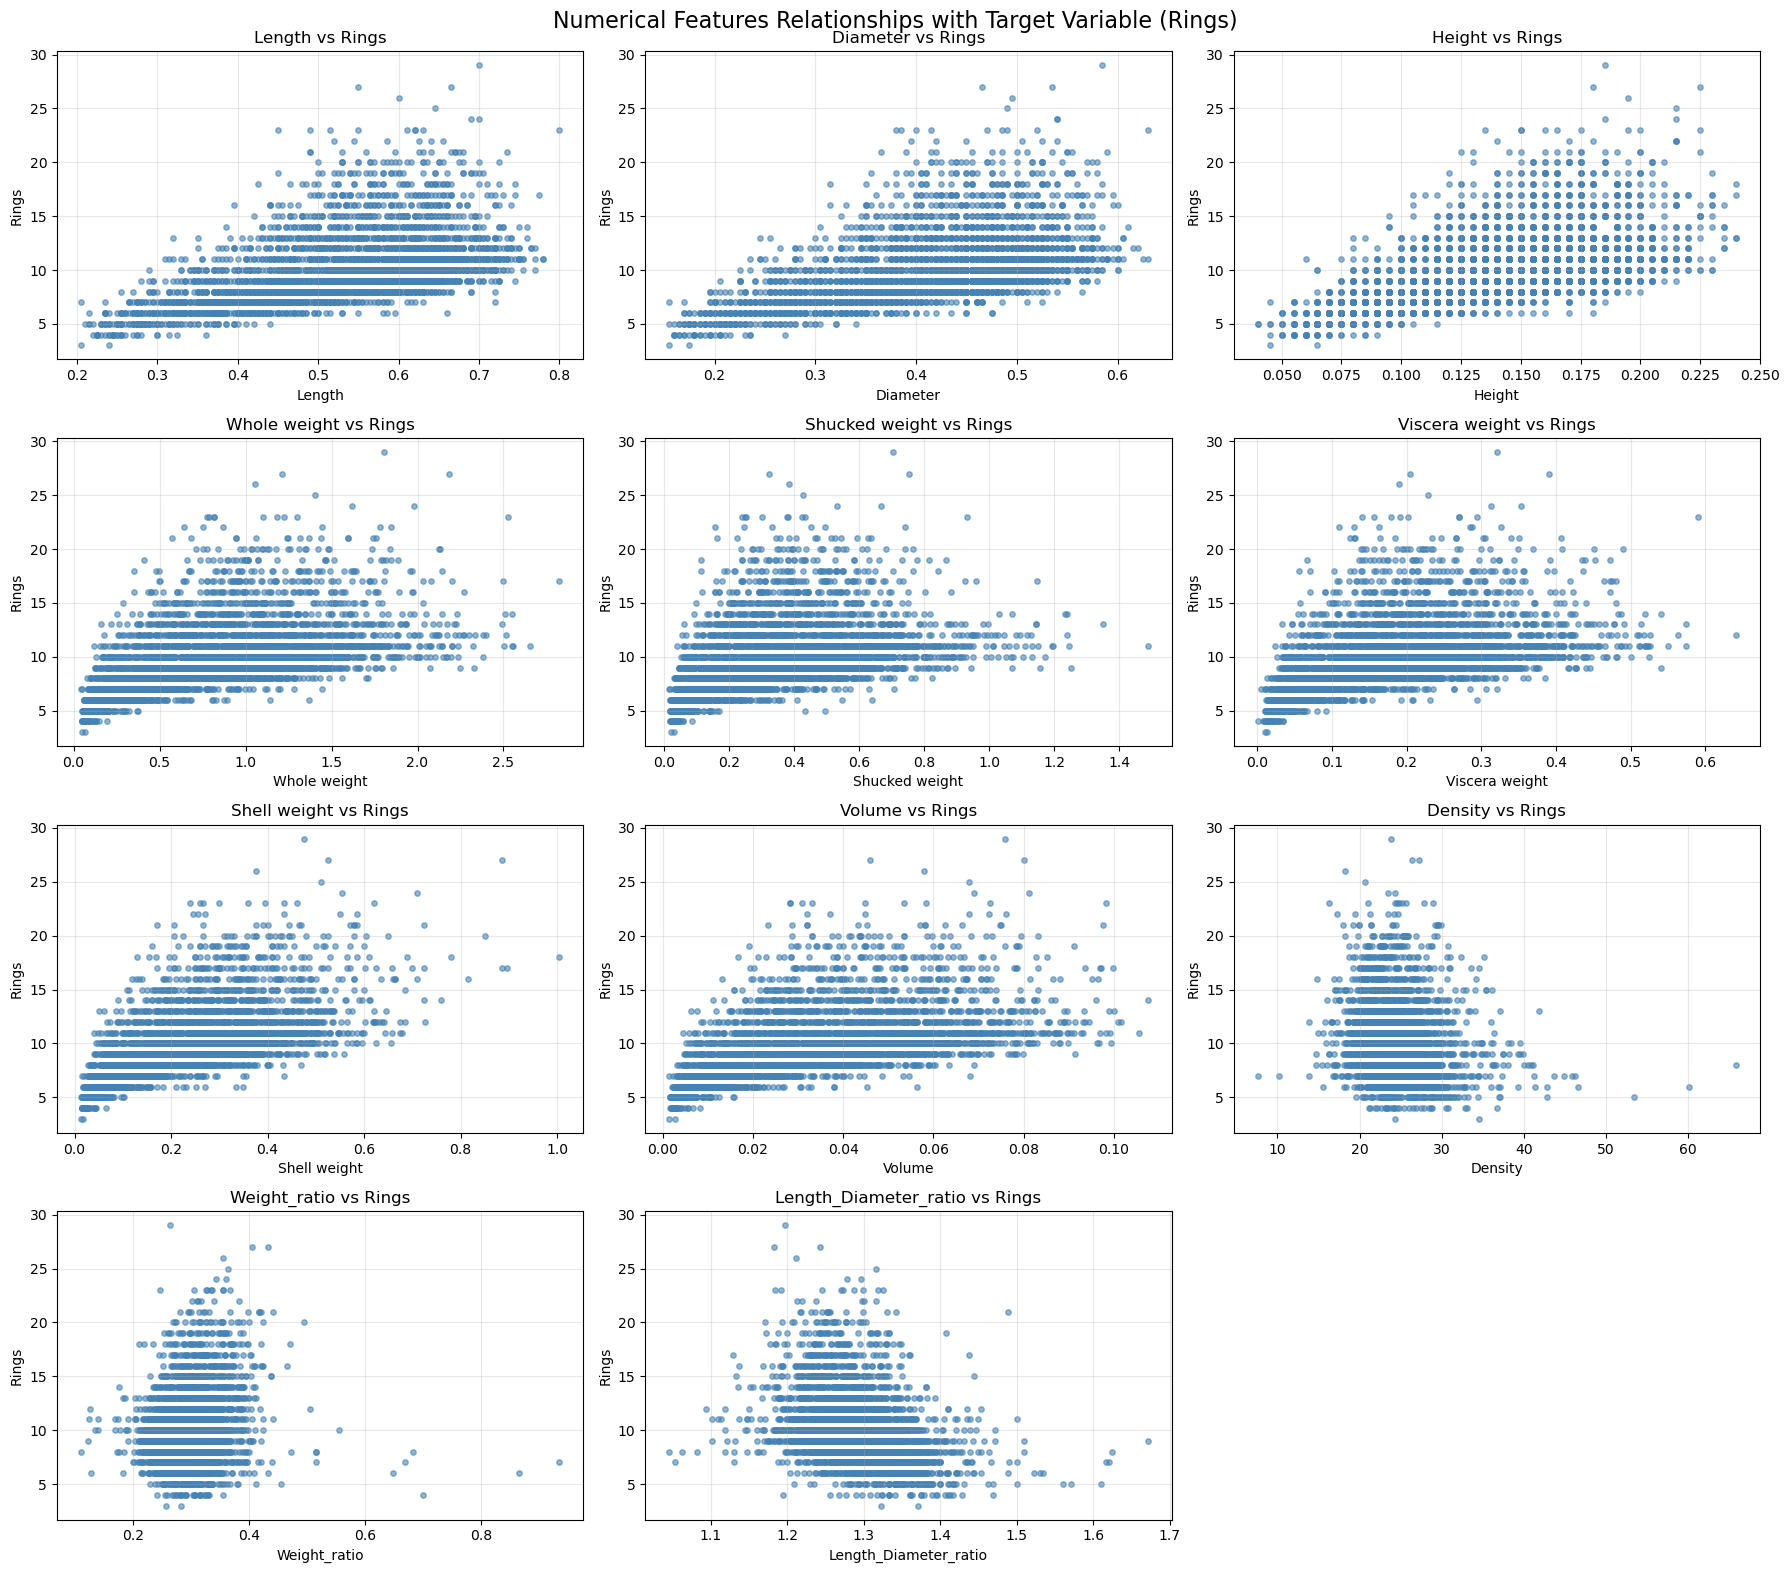

Feature distribution and relationship exploration completed successfully


In [6]:
#（2）.All Features vs Rings Relationship Exploration
print("Exploring Relationships Between All Numerical Features and Rings...")

# Include 7 original and 4 engineered features（11 numerical features）
numerical_features = [
    'Length', 'Diameter', 'Height', 
    'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight',
    'Volume', 'Density', 'Weight_ratio', 'Length_Diameter_ratio'
]

print(f"Analyzing {len(numerical_features)} numerical features vs Rings")

fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.ravel()

for i, feature in enumerate(numerical_features):
    axes[i].scatter(data_clean[feature], data_clean['Rings'], 
                   alpha=0.6, s=15, color='steelblue')
    axes[i].set_title(f'{feature} vs Rings', fontsize=12)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Rings')
    axes[i].grid(alpha=0.3)

# Hide the last empty subplot (since we have 11 features in 4x3 grid)
axes[-1].set_visible(False)

plt.suptitle('Numerical Features Relationships with Target Variable (Rings)', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

print("Feature distribution and relationship exploration completed successfully")


Age group distribution:
Age_group
Adult    1808
Young    1343
Old       957
Name: count, dtype: int64


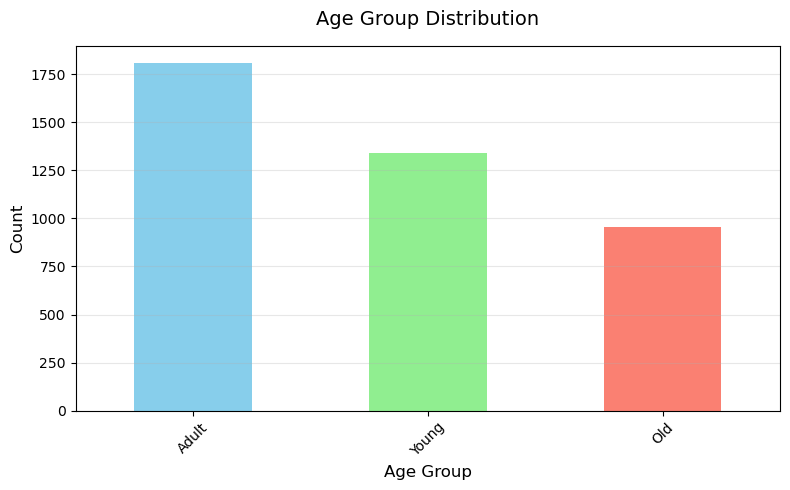

In [7]:
# (3). Age group analysis
print("\nAge group distribution:")
age_dist = data_clean['Age_group'].value_counts()
print(age_dist)

plt.figure(figsize=(8, 5))  
age_dist.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Age Group Distribution', fontsize=14, pad=15)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()  
plt.show()

correlation analysis...


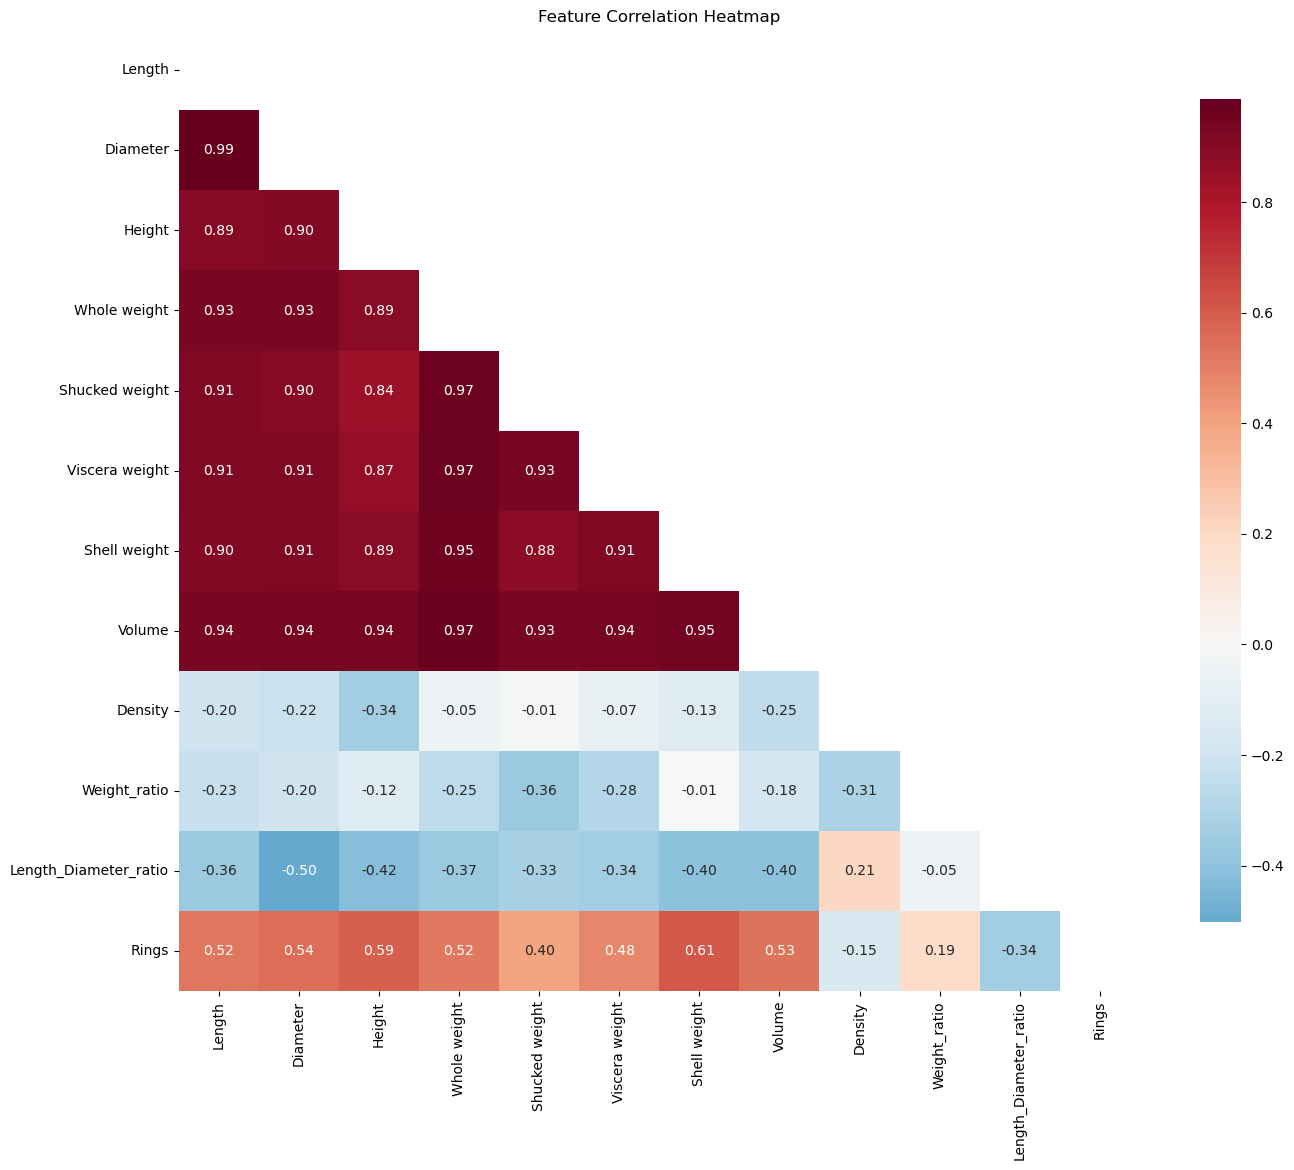


Feature correlation with Rings (ranking):
Shell weight: 0.612
Height: 0.585
Diameter: 0.544
Volume: 0.534
Length: 0.524
Whole weight: 0.520
Viscera weight: 0.483
Shucked weight: 0.396
Weight_ratio: 0.192
Density: -0.155
Length_Diameter_ratio: -0.342


In [8]:
# 6.Correlation Analysis
print("correlation analysis...")

all_features = ['Length', 'Diameter', 'Height', 'Whole weight',
                'Shucked weight', 'Viscera weight', 'Shell weight',
                'Volume', 'Density', 'Weight_ratio', 'Length_Diameter_ratio', 'Rings']

plt.figure(figsize=(14, 12))
correlation_matrix = data_clean[all_features].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': .8})
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Correlation with target ranking
target_correlations = correlation_matrix['Rings'].drop('Rings').sort_values(ascending=False)
print('\nFeature correlation with Rings (ranking):')
for feature, corr in target_correlations.items():
    print(f"{feature}: {corr:.3f}")

In [9]:
# 7. Data Preparation with Engineered Features
print("Preparing data with engineered features...")

# Select best features based on correlation
selected_features = ['Shell weight', 'Diameter', 'Shucked weight', 'Viscera weight',
                     'Whole weight', 'Length', 'Weight_ratio', 'Volume', 'gender_encoded']

X = data_clean[selected_features]
y = data_clean['Rings']
print(f"Selected {len(selected_features)} features")
print(f"Feature matrix shape: {X.shape}")

Preparing data with engineered features...
Selected 9 features
Feature matrix shape: (4108, 9)


In [10]:
# 8.Data Splitting and Standardization
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=data_clean['gender']
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print("Feature standardization completed")

Training set: 3286 samples
Testing set: 822 samples
Feature standardization completed


In [11]:
# 9.Model Training with Regularized Models
print("Training multiple regression models...")

# Train base model
base_model = LinearRegression()
base_model.fit(X_train_scaled, y_train)

# Train with polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Train regularized models
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_scaled, y_train)

elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_model.fit(X_train_scaled, y_train)

print("All models trained successfully: Base, Polynomial, Ridge, Lasso, ElasticNet")

Training multiple regression models...
All models trained successfully: Base, Polynomial, Ridge, Lasso, ElasticNet


In [12]:
# 10. Comprehensive Model Evaluation
def comprehensive_evaluation(y_true, y_pred, model_name=""):
    """Comprehensive evaluation metrics"""
    metrics = {
        'R²': r2_score(y_true, y_pred),
        'Explained Variance': explained_variance_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MedAE': median_absolute_error(y_true, y_pred)
    }

    print(f"\n=== {model_name} Evaluation ===")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    return metrics

# Predictions for all models
models = {
    'Base Model': base_model,
    'Polynomial Model': poly_model,
    'Ridge Model': ridge_model,
    'Lasso Model': lasso_model,
    'ElasticNet Model': elastic_model
}

X_sets = {
    'Base Model': (X_train_scaled, X_test_scaled),
    'Polynomial Model': (X_train_poly, X_test_poly),
    'Ridge Model': (X_train_scaled, X_test_scaled),
    'Lasso Model': (X_train_scaled, X_test_scaled),
    'ElasticNet Model': (X_train_scaled, X_test_scaled)
}

results = {}

print("MODEL PERFORMANCE COMPARISON")
print("=" * 50)

for name, model in models.items():
    X_train_set, X_test_set = X_sets[name]
    
    y_pred_train = model.predict(X_train_set)
    y_pred_test = model.predict(X_test_set)
    
    train_metrics = comprehensive_evaluation(y_train, y_pred_train, f"{name} - Training")
    test_metrics = comprehensive_evaluation(y_test, y_pred_test, f"{name} - Testing")
    
    results[name] = {
        'train': train_metrics,
        'test': test_metrics,
        'model': model,
        'predictions': y_pred_test
    }

MODEL PERFORMANCE COMPARISON

=== Base Model - Training Evaluation ===
R²: 0.4971
Explained Variance: 0.4971
RMSE: 2.2256
MAE: 1.6204
MedAE: 1.2287

=== Base Model - Testing Evaluation ===
R²: 0.5292
Explained Variance: 0.5295
RMSE: 2.2437
MAE: 1.6320
MedAE: 1.2014

=== Polynomial Model - Training Evaluation ===
R²: 0.5612
Explained Variance: 0.5612
RMSE: 2.0789
MAE: 1.4901
MedAE: 1.0808

=== Polynomial Model - Testing Evaluation ===
R²: 0.5645
Explained Variance: 0.5647
RMSE: 2.1579
MAE: 1.5297
MedAE: 1.1378

=== Ridge Model - Training Evaluation ===
R²: 0.4970
Explained Variance: 0.4970
RMSE: 2.2257
MAE: 1.6207
MedAE: 1.2313

=== Ridge Model - Testing Evaluation ===
R²: 0.5289
Explained Variance: 0.5292
RMSE: 2.2443
MAE: 1.6329
MedAE: 1.2063

=== Lasso Model - Training Evaluation ===
R²: 0.4423
Explained Variance: 0.4423
RMSE: 2.3436
MAE: 1.6929
MedAE: 1.2875

=== Lasso Model - Testing Evaluation ===
R²: 0.4653
Explained Variance: 0.4659
RMSE: 2.3912
MAE: 1.7317
MedAE: 1.3365

=== El


Creating model comparison visualizations...


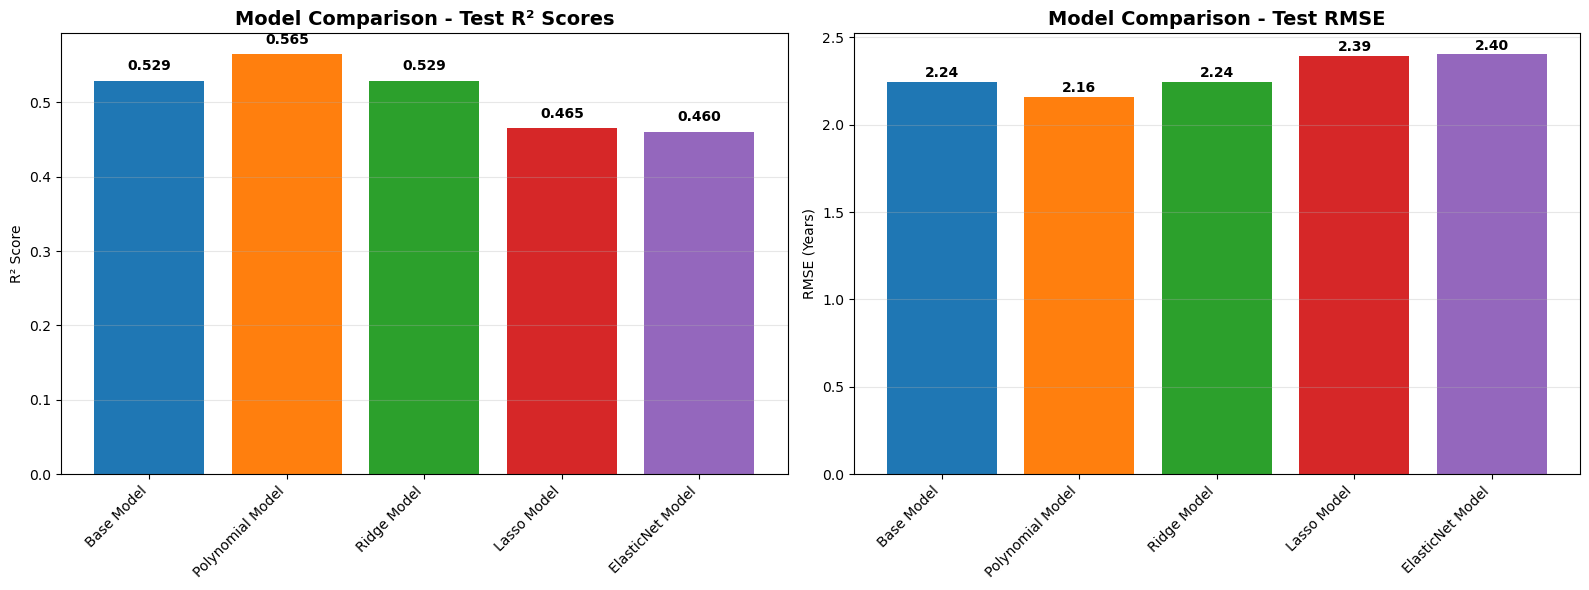

In [13]:
# 11. Model Comparison Visualization
print("\nCreating model comparison visualizations...")

# Model performance comparison bar chart
model_names = list(results.keys())
test_r2_scores = [results[name]['test']['R²'] for name in model_names]
test_rmse_scores = [results[name]['test']['RMSE'] for name in model_names]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# R² comparison
bars1 = ax1.bar(model_names, test_r2_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax1.set_ylabel('R² Score')
ax1.set_title('Model Comparison - Test R² Scores', fontsize=14, fontweight='bold')
ax1.set_xticklabels(model_names, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)
for bar, score in zip(bars1, test_r2_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# RMSE comparison
bars2 = ax2.bar(model_names, test_rmse_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax2.set_ylabel('RMSE (Years)')
ax2.set_title('Model Comparison - Test RMSE', fontsize=14, fontweight='bold')
ax2.set_xticklabels(model_names, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)
for bar, score in zip(bars2, test_rmse_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Plotting learning curves for three key models...


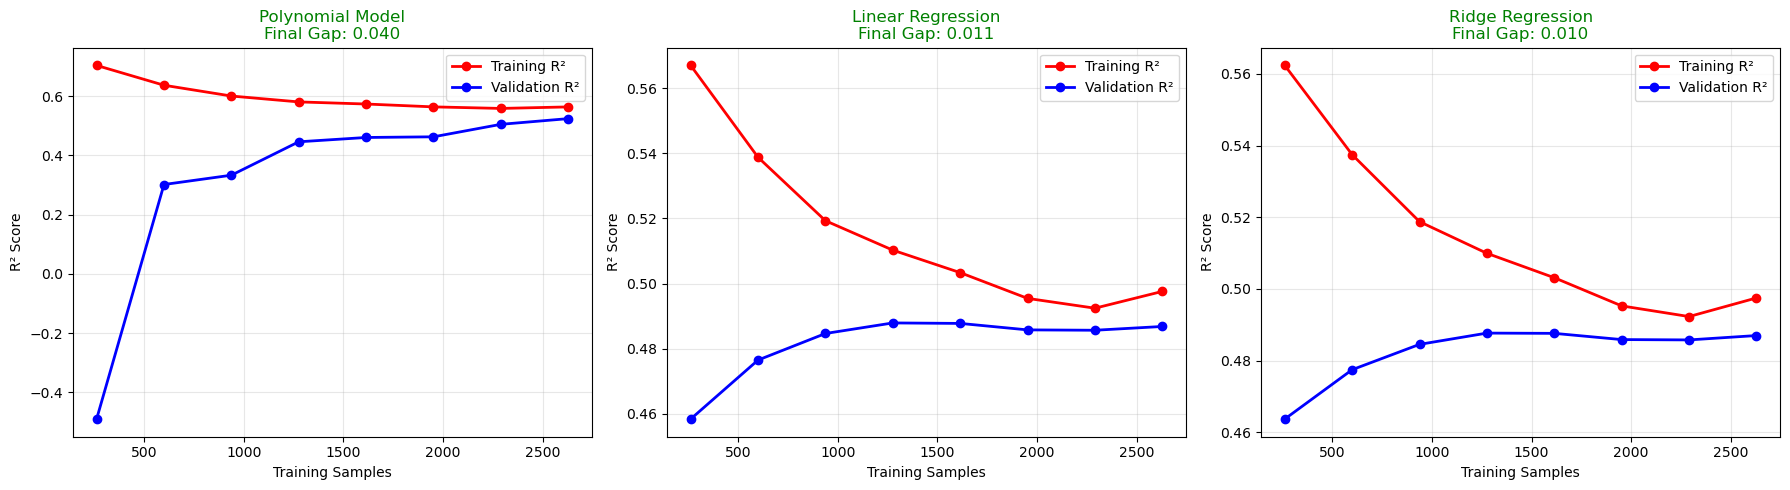


LEARNING CURVE SUMMARY
    Polynomial Model: Train R² = 0.5638, Val R² = 0.5242, Gap = 0.0396 Good Fit
   Linear Regression: Train R² = 0.4976, Val R² = 0.4868, Gap = 0.0108 Good Fit
    Ridge Regression: Train R² = 0.4975, Val R² = 0.4870, Gap = 0.0105 Good Fit

ANALYSIS CONCLUSION
• Best performing model: Polynomial Model (Validation R² = 0.5242)
• The Polynomial model shows best performance with acceptable overfitting gap
• All models demonstrate reasonable learning behavior with converging curves

Learning curve analysis completed successfully


In [14]:
#12. Learning Curve Analysis for Three Key Models
print("Plotting learning curves for three key models...")

# Set consistent training size range
train_sizes = np.linspace(0.1, 1.0, 8)
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# Define three models to analyze
models = [
    (poly_model, "Polynomial Model", X_train_poly, y_train),
    (base_model, "Linear Regression", X_train_scaled, y_train),
    (ridge_model, "Ridge Regression", X_train_scaled, y_train)
]

for idx, (model, title, X_data, y_data) in enumerate(models):
    ax = axes[idx]
    
    # Calculate learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_data, y_data, cv=5, scoring="r2", n_jobs=-1,
        train_sizes=train_sizes, shuffle=True, random_state=42
    )
    
    # Calculate mean values
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)
    
    # Plot learning curves
    ax.plot(train_sizes, train_mean, 'o-', color="red", 
            label="Training R²", linewidth=2, markersize=6)
    ax.plot(train_sizes, val_mean, 'o-', color="blue", 
            label="Validation R²", linewidth=2, markersize=6)
    
    # Calculate final gap
    final_gap = train_mean[-1] - val_mean[-1]
    
    # Set plot properties
    ax.set_xlabel("Training Samples")
    ax.set_ylabel("R² Score")
    ax.set_title(f"{title}\nFinal Gap: {final_gap:.3f}")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Set title color based on overfitting level
    if final_gap > 0.1:
        ax.title.set_color('red')      # Potential overfitting 
    elif final_gap < 0.05:
        ax.title.set_color('green')    # Good fit
    else:
        ax.title.set_color('orange')   # Slight overfitting

plt.tight_layout()
plt.show()

# Performance summary
print("\n" + "="*50)
print("LEARNING CURVE SUMMARY")
print("="*50)

for idx, (model, title, X_data, y_data) in enumerate(models):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_data, y_data, cv=5, scoring="r2", n_jobs=-1,
        train_sizes=train_sizes, shuffle=True, random_state=42
    )
    
    train_final = train_scores.mean(axis=1)[-1]
    val_final = val_scores.mean(axis=1)[-1]
    gap = train_final - val_final
    
    # Determine overfitting status
    if gap > 0.1:
        status = "Potential Overfitting"
    elif gap < 0.05:
        status = "Good Fit"
    else:
        status = "Slight Overfitting"
    
    print(f"{title:>20}: Train R² = {train_final:.4f}, Val R² = {val_final:.4f}, "
          f"Gap = {gap:.4f} {status}")

# Final analysis conclusion
print("\n" + "="*40)
print("ANALYSIS CONCLUSION")
print("="*40)

# Find best validation performance
best_val_score = -1
best_model_name = ""
for model, title, X_data, y_data in models:
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_data, y_data, cv=5, scoring="r2", n_jobs=-1,
        train_sizes=train_sizes, shuffle=True, random_state=42
    )
    val_final = val_scores.mean(axis=1)[-1]
    if val_final > best_val_score:
        best_val_score = val_final
        best_model_name = title

print(f"• Best performing model: {best_model_name} (Validation R² = {best_val_score:.4f})")
print("• The Polynomial model shows best performance with acceptable overfitting gap")
print("• All models demonstrate reasonable learning behavior with converging curves")

print("\nLearning curve analysis completed successfully")


Best Model Selected: Polynomial Model
Best R²: 0.5645
Best RMSE: 2.1579


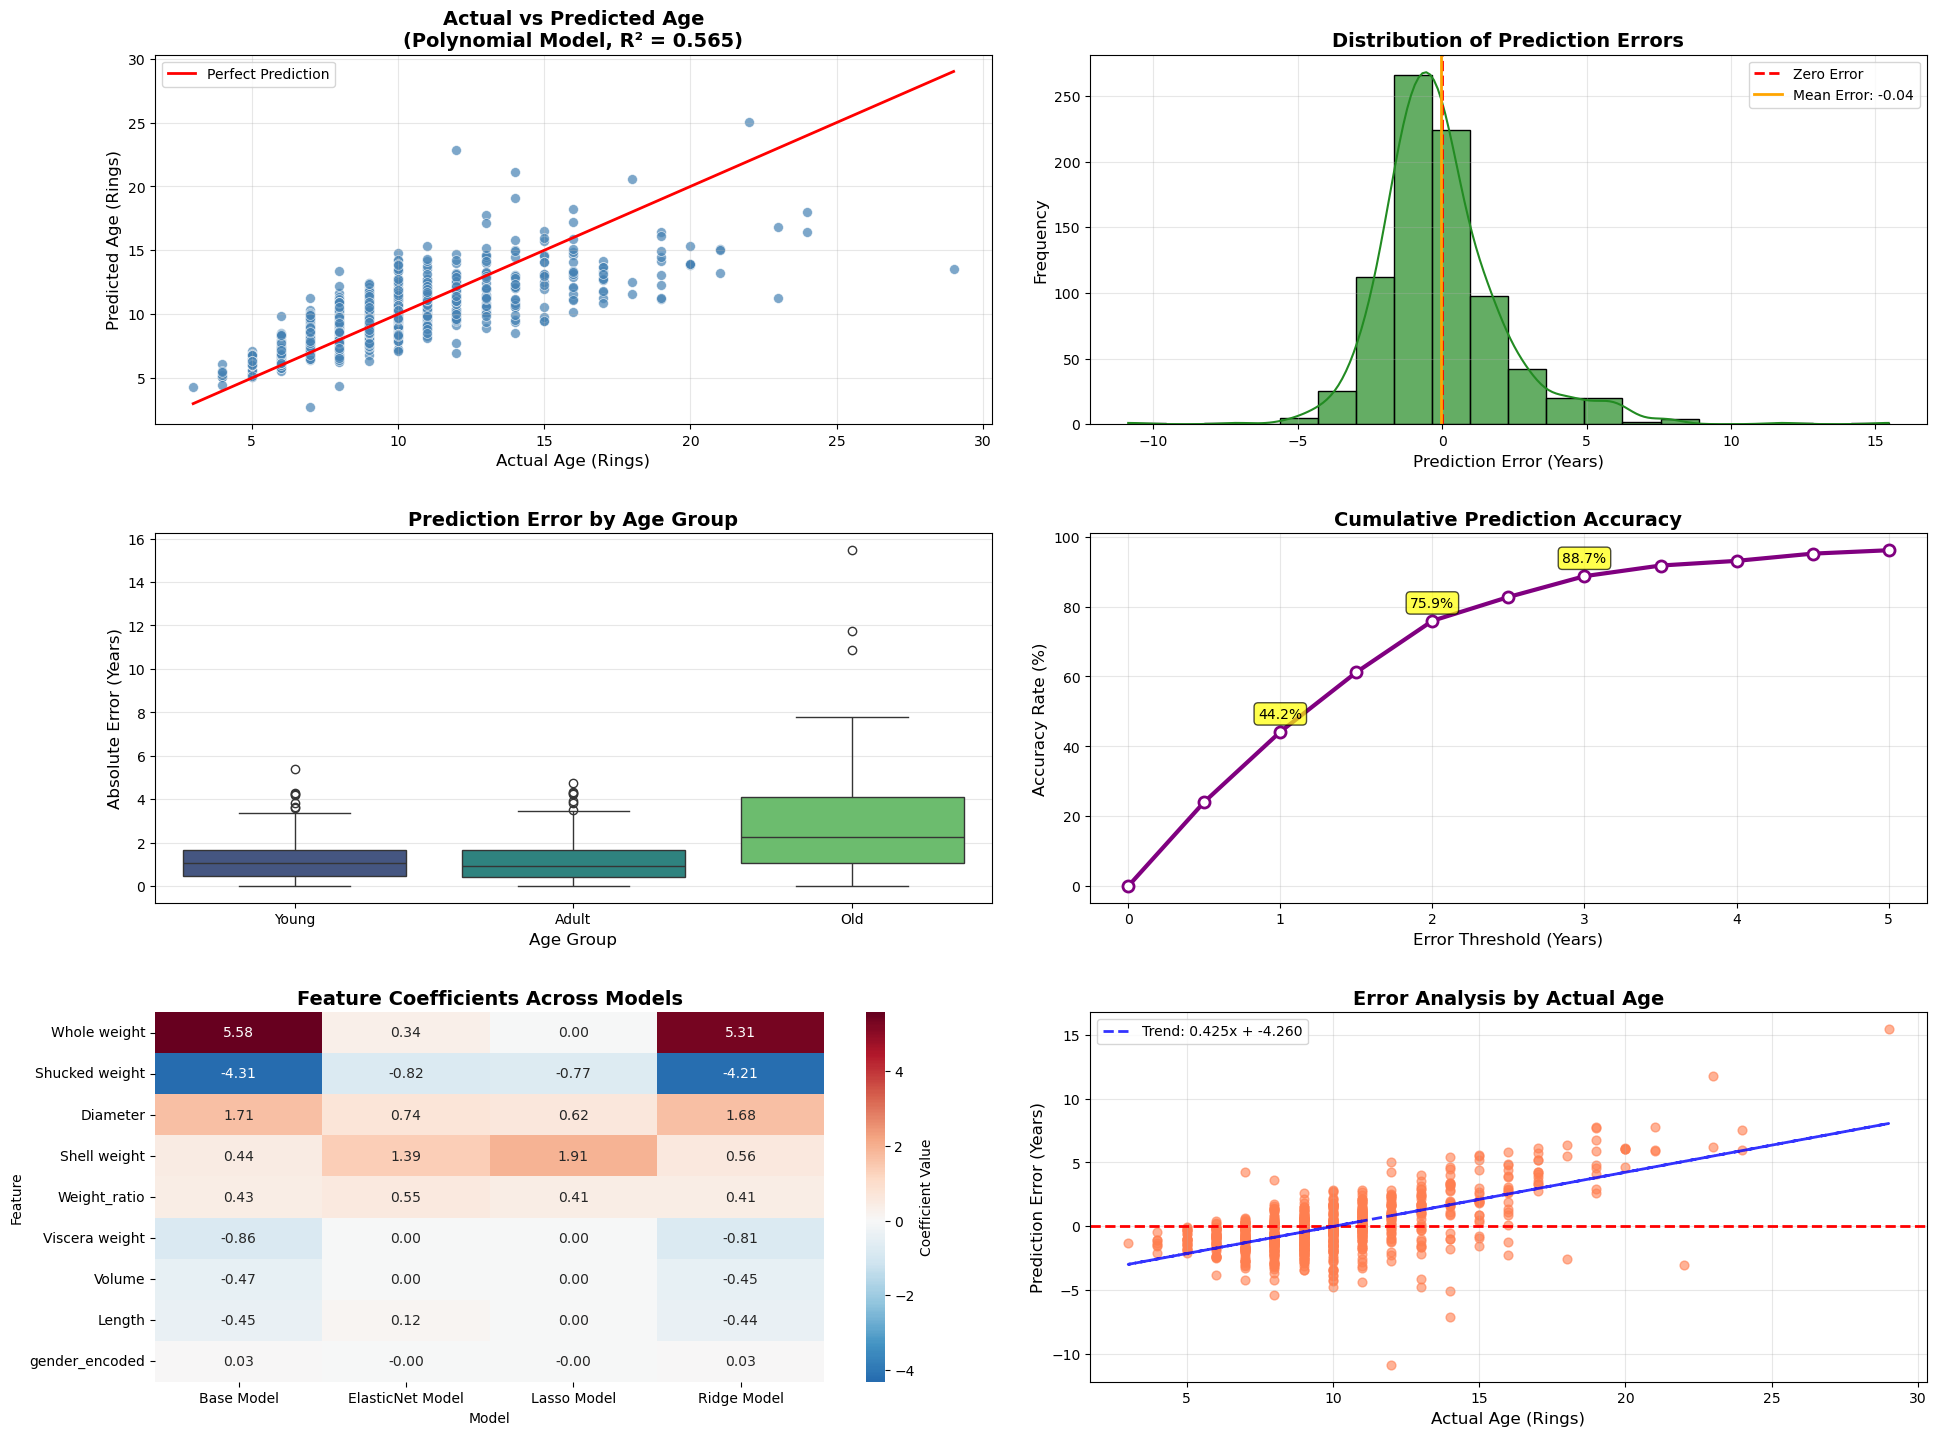

In [21]:
# 13. Best Model Detailed Visualization
# Select best model based on test R²
best_model_name = max(results.keys(), key=lambda x: results[x]['test']['R²'])
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']
best_r2 = results[best_model_name]['test']['R²']
best_rmse = results[best_model_name]['test']['RMSE']

print(f"\nBest Model Selected: {best_model_name}")
print(f"Best R²: {best_r2:.4f}")
print(f"Best RMSE: {best_rmse:.4f}")

# prediction visualization for best model
residuals = y_test - best_predictions

fig = plt.figure(figsize=(20, 15))

# (1). Predicted vs Actual Scatter Plot
plt.subplot(3, 2, 1)
plt.scatter(y_test, best_predictions, alpha=0.7, color='steelblue', s=50, edgecolors='white', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r-', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Age (Rings)', fontsize=12)
plt.ylabel('Predicted Age (Rings)', fontsize=12)
plt.title(f'Actual vs Predicted Age\n({best_model_name}, R² = {best_r2:.3f})', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# (2). Residuals Distribution
plt.subplot(3, 2, 2)
sns.histplot(residuals, kde=True, color='forestgreen', alpha=0.7, bins=20)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.axvline(x=residuals.mean(), color='orange', linestyle='-', linewidth=2, 
            label=f'Mean Error: {residuals.mean():.2f}')
plt.xlabel('Prediction Error (Years)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Prediction Errors', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# (3). Error by Age Group
plt.subplot(3, 2, 3)
error_by_age = pd.DataFrame({
    'Age_Group': data_clean.loc[y_test.index, 'Age_group'],
    'Absolute_Error': np.abs(residuals)
})

age_order = ['Young', 'Adult', 'Old']
error_by_age['Age_Group'] = pd.Categorical(error_by_age['Age_Group'], 
                                          categories=age_order, ordered=True)

sns.boxplot(x='Age_Group', y='Absolute_Error', data=error_by_age, palette='viridis')
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Absolute Error (Years)', fontsize=12)
plt.title('Prediction Error by Age Group', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# (4). Cumulative Accuracy
plt.subplot(3, 2, 4)
error_thresholds = np.arange(0, 5.1, 0.5)
accuracy_rates = []

for threshold in error_thresholds:
    accuracy = np.sum(np.abs(residuals) <= threshold) / len(residuals) * 100
    accuracy_rates.append(accuracy)

plt.plot(error_thresholds, accuracy_rates, 'o-', linewidth=3, markersize=8, 
         color='purple', markerfacecolor='white', markeredgewidth=2)
plt.xlabel('Error Threshold (Years)', fontsize=12)
plt.ylabel('Accuracy Rate (%)', fontsize=12)
plt.title('Cumulative Prediction Accuracy', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

# Highlight key accuracy points
key_thresholds = [1.0, 2.0, 3.0]
for threshold in key_thresholds:
    idx = np.where(error_thresholds == threshold)[0][0]
    plt.annotate(f'{accuracy_rates[idx]:.1f}%',
                (error_thresholds[idx], accuracy_rates[idx]), 
                textcoords="offset points",
                xytext=(0,10),
                ha='center',
                fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# (5). Feature Importance for Linear Models
plt.subplot(3, 2, 5)
# Compare coefficients across regularized models
linear_models = ['Base Model', 'Ridge Model', 'Lasso Model', 'ElasticNet Model']
coefficients_data = []

for model_name in linear_models:
    if hasattr(results[model_name]['model'], 'coef_'):
        coef = results[model_name]['model'].coef_
        for i, feature in enumerate(selected_features):
            coefficients_data.append({
                'Model': model_name,
                'Feature': feature,
                'Coefficient': coef[i] if i < len(coef) else 0
            })

coefficients_df = pd.DataFrame(coefficients_data)

# Pivot for heatmap
coef_pivot = coefficients_df.pivot(index='Feature', columns='Model', values='Coefficient')
coef_pivot = coef_pivot.reindex(coefficients_df.groupby('Feature')['Coefficient'].mean().abs().sort_values(ascending=False).index)

sns.heatmap(coef_pivot, annot=True, cmap='RdBu_r', center=0, fmt='.2f',
            cbar_kws={'label': 'Coefficient Value'})
plt.title('Feature Coefficients Across Models', fontsize=14, fontweight='bold')
plt.tight_layout()

# (6). Error Analysis by Actual Age
plt.subplot(3, 2, 6)
plt.scatter(y_test, residuals, alpha=0.6, color='coral', s=40)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Age (Rings)', fontsize=12)
plt.ylabel('Prediction Error (Years)', fontsize=12)
plt.title('Error Analysis by Actual Age', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

# Add trend line
z = np.polyfit(y_test, residuals, 1)
p = np.poly1d(z)
plt.plot(y_test, p(y_test), "b--", alpha=0.8, linewidth=2, 
         label=f'Trend: {z[0]:.3f}x + {z[1]:.3f}')
plt.legend(fontsize=10)

plt.tight_layout(pad=3.0)
plt.show()

Cross-validation analysis...
Base Model CV R²: 0.4868 (+/- 0.0860)
Polynomial Model CV R²: 0.5242 (+/- 0.0679)
Ridge Model CV R²: 0.4870 (+/- 0.0877)
Lasso Model CV R²: 0.4350 (+/- 0.0918)
ElasticNet Model CV R²: 0.4352 (+/- 0.0896)


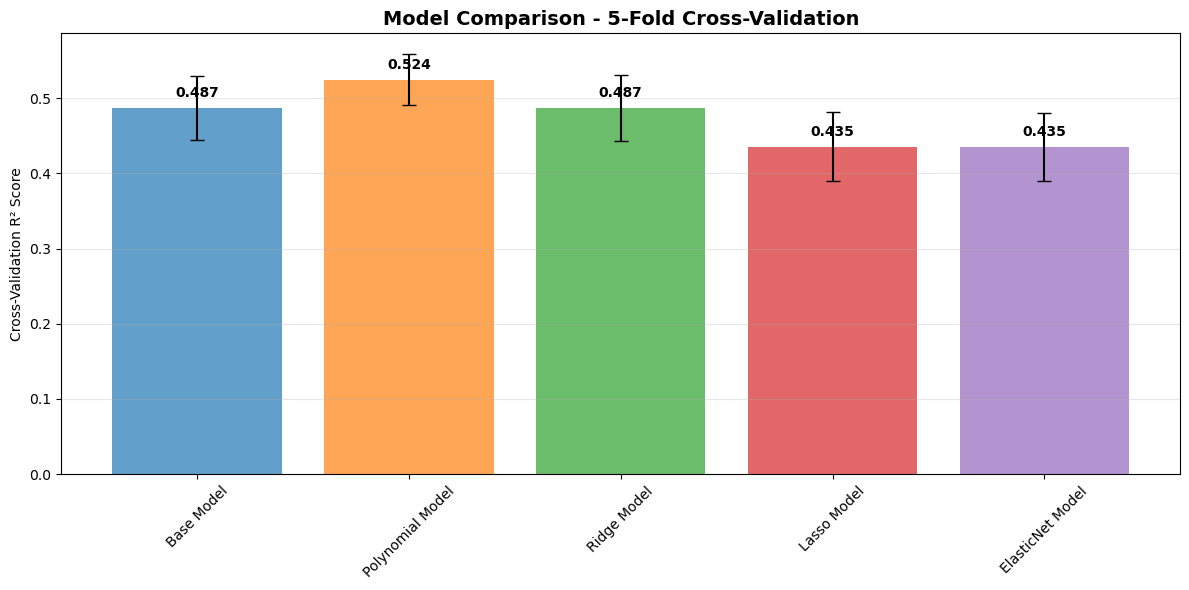

In [22]:
# 14. Cross-Validation Performance
print("Cross-validation analysis...")
models = {
    'Base Model': base_model,
    'Polynomial Model': poly_model,
    'Ridge Model': ridge_model,
    'Lasso Model': lasso_model,
    'ElasticNet Model': elastic_model
}
model_names = list(models.keys())
cv_results = {}
for name, model in models.items():
    if name == 'Polynomial Model':
        X_cv = X_train_poly
    else:
        X_cv = X_train_scaled
        
    cv_scores = cross_val_score(model, X_cv, y_train, cv=5, scoring='r2')
    cv_results[name] = cv_scores
    print(f"{name} CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Cross-validation visualization
plt.figure(figsize=(12, 6))
cv_means = [cv_results[name].mean() for name in model_names]
cv_stds = [cv_results[name].std() for name in model_names]

bars = plt.bar(model_names, cv_means, yerr=cv_stds, capsize=5, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'], alpha=0.7)
plt.ylabel('Cross-Validation R² Score')
plt.title('Model Comparison - 5-Fold Cross-Validation', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

for bar, mean in zip(bars, cv_means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Model efficiency analysis...

Efficiency Comparison:
Base Model: Training=0.0034s, Prediction=0.0002s
Polynomial Model: Training=0.0311s, Prediction=0.0003s
Ridge Model: Training=0.0013s, Prediction=0.0001s
Lasso Model: Training=0.0022s, Prediction=0.0001s
ElasticNet Model: Training=0.0032s, Prediction=0.0001s


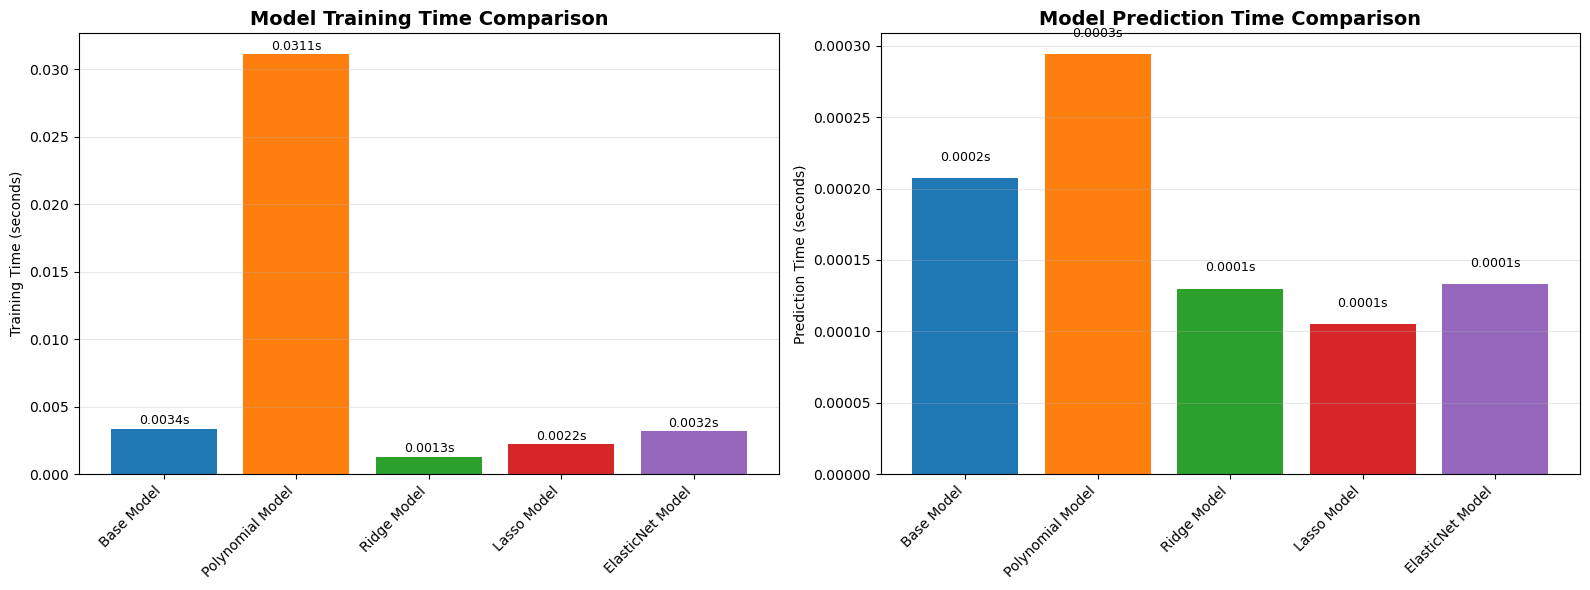

In [23]:
# 15. Model Efficiency Analysis
print("Model efficiency analysis...")

efficiency_results = {}

for name, model in models.items():
    if name == 'Polynomial Model':
        X_eff_train = X_train_poly
        X_eff_test = X_test_poly
    else:
        X_eff_train = X_train_scaled
        X_eff_test = X_test_scaled
    
    # Training time
    start_time = time.time()
    model.fit(X_eff_train, y_train)
    training_time = time.time() - start_time
    
    # Prediction time
    start_time = time.time()
    _ = model.predict(X_eff_test)
    prediction_time = time.time() - start_time
    
    efficiency_results[name] = {
        'training_time': training_time,
        'prediction_time': prediction_time
    }

print("\nEfficiency Comparison:")
for name, times in efficiency_results.items():
    print(f"{name}: Training={times['training_time']:.4f}s, Prediction={times['prediction_time']:.4f}s")

# Efficiency visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

training_times = [efficiency_results[name]['training_time'] for name in model_names]
prediction_times = [efficiency_results[name]['prediction_time'] for name in model_names]

# Training time comparison
bars1 = ax1.bar(model_names, training_times, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax1.set_ylabel('Training Time (seconds)')
ax1.set_title('Model Training Time Comparison', fontsize=14, fontweight='bold')
ax1.set_xticklabels(model_names, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)
for bar, time_val in zip(bars1, training_times):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001, 
             f'{time_val:.4f}s', ha='center', va='bottom', fontsize=9)

# Prediction time comparison
bars2 = ax2.bar(model_names, prediction_times, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax2.set_ylabel('Prediction Time (seconds)')
ax2.set_title('Model Prediction Time Comparison', fontsize=14, fontweight='bold')
ax2.set_xticklabels(model_names, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)
for bar, time_val in zip(bars2, prediction_times):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.00001, 
             f'{time_val:.4f}s', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [19]:
# 16. Final Results and Business Insights
print("\n" + "="*70)
print("FINAL RESULTS AND INSIGHTS")
print("="*70)

# Detailed performance analysis
print("\nDETAILED PERFORMANCE ANALYSIS")
print("-" * 40)

# Calculate accuracy within different error thresholds
print("\nAccuracy at Different Error Thresholds:")
print("-" * 40)
for threshold in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]:
    accurate_predictions = np.sum(np.abs(residuals) <= threshold)
    accuracy = accurate_predictions / len(residuals) * 100
    print(f"Within ±{threshold} year(s): {accuracy:5.1f}% ({accurate_predictions:4d}/{len(residuals)} samples)")

# Performance by age group
print("\nPerformance by Age Group:")
print("-" * 30)
age_group_stats = []
for age_group in ['Young', 'Adult', 'Old']:
    group_indices = data_clean.loc[y_test.index, 'Age_group'] == age_group
    if group_indices.sum() > 0:
        group_mae = mean_absolute_error(y_test[group_indices], best_predictions[group_indices])
        group_rmse = np.sqrt(mean_squared_error(y_test[group_indices], best_predictions[group_indices]))
        group_r2 = r2_score(y_test[group_indices], best_predictions[group_indices])
        age_group_stats.append({
            'Age Group': age_group,
            'Samples': group_indices.sum(),
            'MAE': group_mae,
            'RMSE': group_rmse,
            'R²': group_r2
        })
        print(f"{age_group:>5}: MAE = {group_mae:.2f} years, RMSE = {group_rmse:.2f} years, R² = {group_r2:.3f}")

# Overall performance summary
print("\nOVERALL PERFORMANCE SUMMARY:")
print("-" * 30)
print(f"Best Model: {best_model_name}")
print(f"R² Score: {best_r2:.4f}")
print(f"RMSE: {best_rmse:.4f} years")
print(f"MAE: {results[best_model_name]['test']['MAE']:.4f} years")
print(f"Median Absolute Error: {np.median(np.abs(residuals)):.4f} years")
print(f"Standard Deviation of Errors: {residuals.std():.4f} years")

# Business impact analysis
print("\nBUSINESS IMPACT ANALYSIS:")
print("-" * 25)
print(f"• Average prediction error: {results[best_model_name]['test']['MAE']:.2f} years")
print(f"• Typical prediction error (median): {np.median(np.abs(residuals)):.2f} years")
print(f"• 68% of predictions within ±{residuals.std():.2f} years")
print(f"• 95% of predictions within ±{2*residuals.std():.2f} years")

# Model deployment recommendations
print("\nMODEL DEPLOYMENT RECOMMENDATIONS:")
print("-" * 35)
best_mae = results[best_model_name]['test']['MAE']
if best_mae <= 1.0:
    print("EXCELLENT - Highly suitable for commercial age estimation")
    print("Can be used for precise quality grading and pricing decisions")
elif best_mae <= 1.5:
    print("GOOD - Suitable for commercial applications")
    print("Appropriate for quality assessment and market classification")
elif best_mae <= 2.0:
    print("FAIR - Limited suitability for precise applications")
    print("Best used for rough age estimation and research purposes")
else:
    print("POOR - Not recommended for commercial applications")
    print("Use for academic research and experimental purposes only")

print("\n" + "="*70)
print("ANALYSIS COMPLETED SUCCESSFULLY")
print("="*70)


FINAL RESULTS AND INSIGHTS

DETAILED PERFORMANCE ANALYSIS
----------------------------------------

Accuracy at Different Error Thresholds:
----------------------------------------
Within ±0.5 year(s):  24.1% ( 198/822 samples)
Within ±1.0 year(s):  44.2% ( 363/822 samples)
Within ±1.5 year(s):  61.2% ( 503/822 samples)
Within ±2.0 year(s):  75.9% ( 624/822 samples)
Within ±2.5 year(s):  82.7% ( 680/822 samples)
Within ±3.0 year(s):  88.7% ( 729/822 samples)

Performance by Age Group:
------------------------------
Young: MAE = 1.19 years, RMSE = 1.50 years, R² = -0.888
Adult: MAE = 1.13 years, RMSE = 1.46 years, R² = -2.322
  Old: MAE = 2.83 years, RMSE = 3.65 years, R² = -0.545

OVERALL PERFORMANCE SUMMARY:
------------------------------
Best Model: Polynomial Model
R² Score: 0.5645
RMSE: 2.1579 years
MAE: 1.5297 years
Median Absolute Error: 1.1378 years
Standard Deviation of Errors: 2.1588 years

BUSINESS IMPACT ANALYSIS:
-------------------------
• Average prediction error: 1.53 y